# EDA: Tuning Mask Generation Parameters

**Objective:** This notebook will guide you through an exploratory data analysis (EDA) to find the optimal `intensity_thresh` and `min_area` parameters for the mask generation script (`setup_data_update.py`).

## 1. Setup

First, let's import the necessary libraries and define the paths to your data. Make sure you have run `pip install -r requirements.txt` to install `ipywidgets`.

In [2]:
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Adjust these paths if your data is located elsewhere
RAW_DATA_FOLDER = 'data/images'

# --- Find a sample set of images to analyze ---
all_b_files = [f for f in os.listdir(RAW_DATA_FOLDER) if f.endswith('b.PNG')]
if not all_b_files:
    raise FileNotFoundError(f'No `*b.PNG` files found in {RAW_DATA_FOLDER}. Please check your data.')
    
# Select a random image set for analysis
sample_b_file = random.choice(all_b_files)
base_name = sample_b_file.replace('b.PNG', '')

filename_a = base_name + 'a.PNG'
filename_b = sample_b_file
filename_c = base_name + 'c.PNG'

src_a = os.path.join(RAW_DATA_FOLDER, filename_a)
src_b = os.path.join(RAW_DATA_FOLDER, filename_b)
src_c = os.path.join(RAW_DATA_FOLDER, filename_c)

print(f'Analyzing sample image set: {base_name}')

# Load 16-bit images
try:
    img_a_16bit = Image.open(src_a)
    img_b_16bit = Image.open(src_b)
    img_c_16bit = Image.open(src_c)
except FileNotFoundError as e:
    print(f'Error: {e}. Make sure all three angle files (a, b, c) exist for the chosen sample.')
    
# Convert to numpy arrays
np_a_16bit = np.array(img_a_16bit)
np_b_16bit = np.array(img_b_16bit)
np_c_16bit = np.array(img_c_16bit)

# Normalize to 8-bit for visualization and thresholding
np_a_8bit = cv2.normalize(np_a_16bit, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
np_b_8bit = cv2.normalize(np_b_16bit, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
np_c_8bit = cv2.normalize(np_c_16bit, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

Analyzing sample image set: B0075


## 2. Part 1: Finding the `intensity_thresh`

The `intensity_thresh` parameter (0-255) determines how dark a pixel needs to be to be considered a potential defect. We want to find a value that separates the dark defects from the brighter, uniform background.

### Plotting Intensity Histograms
A histogram shows the distribution of pixel intensities. We are looking for a 'valley' between the large peak (background) and the smaller tail/hump on the left (defects).

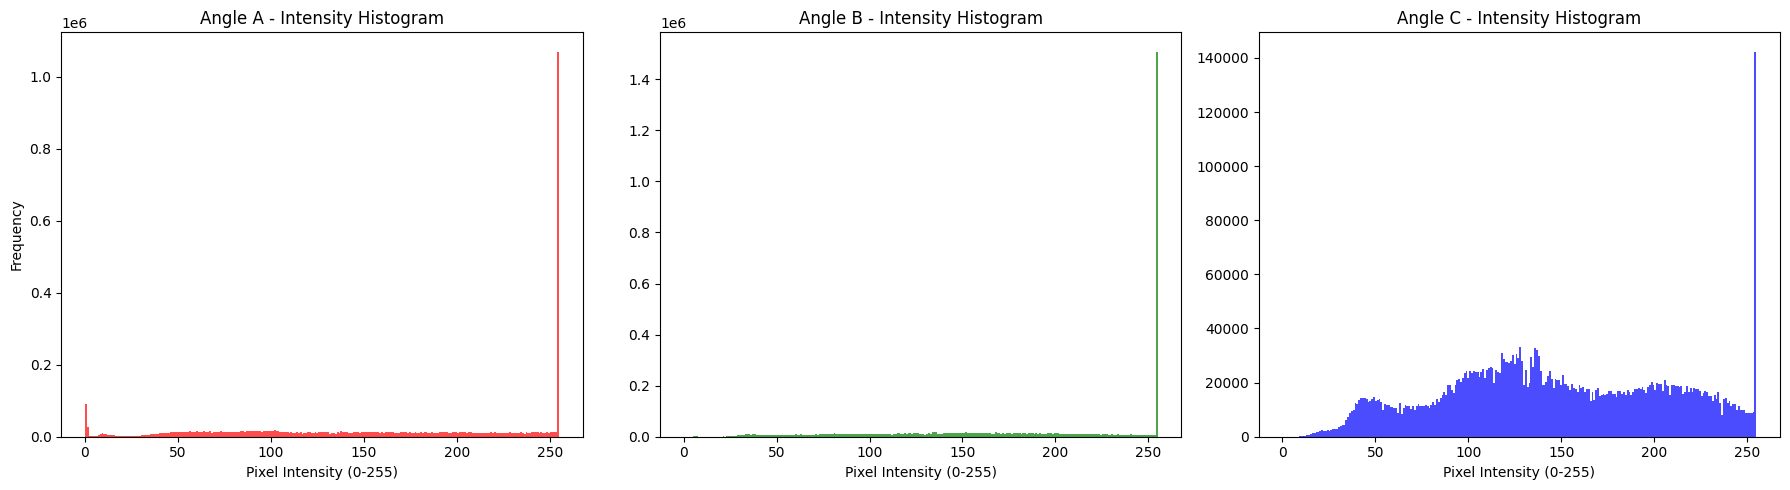

In [3]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(np_a_8bit.ravel(), bins=256, range=(0, 255), color='red', alpha=0.7)
plt.title('Angle A - Intensity Histogram')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(np_b_8bit.ravel(), bins=256, range=(0, 255), color='green', alpha=0.7)
plt.title('Angle B - Intensity Histogram')
plt.xlabel('Pixel Intensity (0-255)')

plt.subplot(1, 3, 3)
plt.hist(np_c_8bit.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title('Angle C - Intensity Histogram')
plt.xlabel('Pixel Intensity (0-255)')

plt.tight_layout()
plt.show()

### Interactive Thresholding

Use the slider below to visually inspect the effect of different `intensity_thresh` values. The goal is to select a value that highlights the defects clearly across all three angles without introducing too much noise from the background.

The mask logic requires a pixel to be below the threshold in **all three** images. The preview below shows the resulting mask.

In [4]:
@interact(threshold=widgets.IntSlider(min=0, max=255, step=1, value=40, description='Intensity Threshold'))
def interactive_thresholding(threshold):
    # A pixel is a defect candidate if it's dark in ALL three channels
    mask_a = np_a_8bit < threshold
    mask_b = np_b_8bit < threshold
    mask_c = np_c_8bit < threshold
    combined_mask = np.logical_and.reduce([mask_a, mask_b, mask_c])
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(np_b_8bit, cmap='gray')
    plt.title('Original Image (Angle B)')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title(f'Resulting Mask (Thresh={threshold})')
    plt.axis('off')
    
    plt.show()

interactive(children=(IntSlider(value=40, description='Intensity Threshold', max=255), Output()), _dom_classes…

## 3. Part 2: Finding the `min_area`

Now that you have a good `intensity_thresh`, let's find a `min_area`. This parameter removes small, noisy detections that are unlikely to be real defects.

First, set the `CHOSEN_INTENSITY_THRESH` variable below to the value you found in Part 1.

In [5]:
# --------------------------------------------------
# !! SET THIS VALUE from your analysis in Part 1 !!
CHOSEN_INTENSITY_THRESH = 40
# --------------------------------------------------

# Re-create the initial mask using the chosen threshold
mask_a = np_a_8bit < CHOSEN_INTENSITY_THRESH
mask_b = np_b_8bit < CHOSEN_INTENSITY_THRESH
mask_c = np_c_8bit < CHOSEN_INTENSITY_THRESH
initial_mask = np.logical_and.reduce([mask_a, mask_b, mask_c])
initial_mask_8bit = (initial_mask * 255).astype(np.uint8)

# Perform morphological opening to remove salt noise before component analysis
kernel = np.ones((3, 3), np.uint8)
opened_mask = cv2.morphologyEx(initial_mask_8bit, cv2.MORPH_OPEN, kernel, iterations=1)

# Find all connected components and calculate their areas
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(opened_mask)

# Get the area of each component (excluding the background, label 0)
component_areas = stats[1:, cv2.CC_STAT_AREA] # All rows, 5th column (area)

print(f'Found {len(component_areas)} potential defect components.')

Found 21 potential defect components.


### Plotting Component Area Distribution

A histogram of the component areas will usually show a large number of very small components (noise) and a smaller number of large components (real defects). We want to find a `min_area` that separates these two groups.

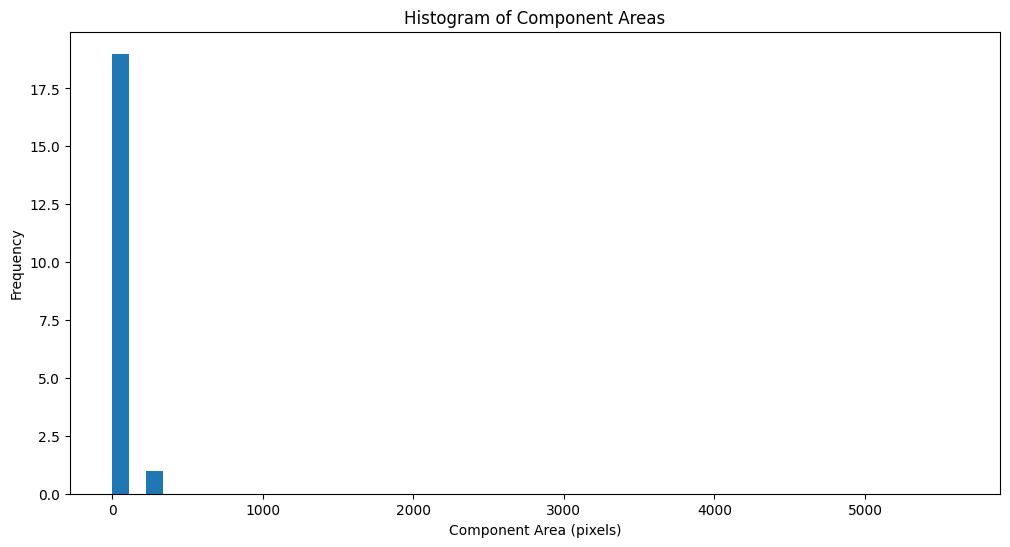

In [6]:
if len(component_areas) > 0:
    plt.figure(figsize=(12, 6))
    plt.hist(component_areas, bins=50, range=(0, np.percentile(component_areas, 99) if len(component_areas) > 1 else 100))
    plt.title('Histogram of Component Areas')
    plt.xlabel('Component Area (pixels)')
    plt.ylabel('Frequency')
    plt.show()
else:
    print('No components found with the current threshold.')

### Interactive Area Filtering

Use the slider below to see how different `min_area` values affect the final mask. Find a value that removes the small noise while keeping the real defects.

In [9]:
if len(component_areas) > 0:
    max_area_for_slider = int(np.percentile(component_areas, 99)) if len(component_areas) > 1 else 100
    
    @interact(min_area=widgets.IntSlider(min=0, max=max_area_for_slider, step=1, value=25, description='Min Area'))
    def interactive_area_filtering(min_area):
        cleaned_mask = np.zeros_like(opened_mask)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                cleaned_mask[labels == i] = 255
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(opened_mask, cmap='gray')
        plt.title('Mask Before Area Filtering')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cleaned_mask, cmap='gray')
        plt.title(f'Final Mask (Min Area={min_area})')
        plt.axis('off')
        
        plt.show()
else:
    print('No components to filter.')

interactive(children=(IntSlider(value=25, description='Min Area', max=5616), Output()), _dom_classes=('widget-…

## 4. Conclusion

Once you are satisfied with your chosen `intensity_thresh` and `min_area`, update the corresponding `INTENSITY_THRESH` and `MIN_AREA` variables at the top of the `setup_data_update.py` script and run it to regenerate all the masks with the new, optimized parameters.